In [1]:
import import_ipynb
import darknet
import util

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import math
import warnings

warnings.filterwarnings('ignore')

importing Jupyter notebook from darknet.ipynb
importing Jupyter notebook from util.ipynb


In [2]:
classes = [
'aeroplane',
'bicycle',
'bird',
'boat',
'bottle',
'bus',
'car',
'cat',
'chair',
'cow',
'diningtable',
'dog',
'horse',
'motorbike',
'person',
'pottedplant',
'sheep',
'sofa',
'train',
'tvmonitor']

In [3]:
anchors = [
    [1.08, 1.19],
    [3.42, 4.41],
    [6.63, 11.38],
    [9.42, 5.11],
    [16.62, 10.52]
]

In [4]:
def predict_transform(input, anchors, inp_dim, confidence, num_anchors = 5, num_classes = 20):
    
    nA = num_anchors  # number of anchors
    nB = input.size(0)  # number of batches
    nG = input.size(2)  # number of grid size
    nC = num_classes
    stride = inp_dim / nG
    
    # Compute outputs
    x = torch.sigmoid(input[..., 0]) # sigmoid each x input
    y = torch.sigmoid(input[..., 1]) # sigmoid each y input
    
    w = input[..., 2] # take the brute predicted weight
    h = input[..., 3] # take the brute predicted height
    
    pred_conf = input[..., 4] # take the prediction confidence
    pred_cls = input[..., 5:] # take the array of the classes
    
    grid_x = torch.arange(nG).repeat(nG, 1).view([1, 1, nG, nG]).type(torch.cuda.FloatTensor) # x offset mask
    grid_y = torch.arange(nG).repeat(nG, 1).t().view([1, 1, nG, nG]).type(torch.cuda.FloatTensor) # y offset mask
    
    # The anchor must be normalized based on the number of grid cells
    scaled_anchors = torch.cuda.FloatTensor([(a_w / stride, a_h / stride) for a_w, a_h in anchors])
    
    anchor_w = scaled_anchors[:, 0:1].view((1, nA, 1, 1))
    anchor_h = scaled_anchors[:, 1:2].view((1, nA, 1, 1))
    
    # Add offset and scale with anchors
    pred_boxes = torch.cuda.FloatTensor(input[..., :].shape)
    pred_boxes[..., 0] = x.data + grid_x
    pred_boxes[..., 1] = y.data + grid_y
    pred_boxes[..., 2] = torch.exp(w.data) * anchor_w
    pred_boxes[..., 3] = torch.exp(h.data) * anchor_h
    
    pred_boxes[..., 4] = torch.sigmoid(pred_conf.data)
    pred_boxes[..., 5:] = torch.softmax(pred_cls.data, dim=4)
    
    best_class, best_idx = torch.max(pred_boxes[..., 5:], dim=4)
    
    
    result = []
    
    for i, batch in enumerate(pred_boxes):
        for j, anchor in enumerate(batch):
            for k, grid1 in enumerate(anchor):
                for l, grid2 in enumerate(grid1):
                    if (grid2[4].item() * best_class[i, j, k, l].item()) > confidence:
                        result.append((grid2[0].item(), grid2[1].item(), grid2[2].item(), grid2[3].item(), torch.argmax(grid2[5:]).item()))
    
    result = [int(x * stride) if i < len(values) -1 else x for values in result for i, x in enumerate(values)]
    objects = []
    
    
    for i in range(0, len(result), 5):
        obj = (result[i], result[i+1], result[i+2], result[i+3], result[i+4])
        objects.append(obj)
        
    return objects

In [5]:
def draw_grid(coords, image):

    for (x, y, w, h, name) in coords:
            #print(x, y, w, h, classes[name.item()])
            #print(classes[name])
            #if classes[name] == 'bicycle':
            image = cv2.rectangle(image, (int(x-w/2), int(y-h/2)), (int(x+w/2), int(y+h/2)), (0, 255, 0), 2)
        
    return image

In [6]:
net_util = darknet.UtilTinyYolo('network.txt')
net_info, anchors, layers = net_util.build_network()
layers = darknet.load_weights(os.path.join(os.getcwd(), 'yolov2-tiny-voc.weights'), layers)

15867885
15867885


In [7]:
darknet = darknet.DarkNet(net_info, layers, anchors)

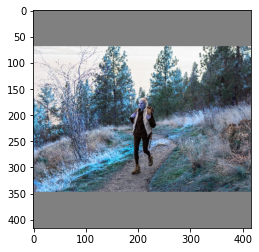

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


path = os.path.join(os.getcwd(), 'person.jpg')

img = cv2.imread(path)
h, w, _ = img.shape

dim_diff = np.abs(h - w)
pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2

# Determine padding
pad = ((pad1, pad2), (0, 0), (0, 0)) if h <= w else ((0, 0), (pad1, pad2), (0, 0))

# Add padding
pad_img = np.pad(img, pad, 'constant', constant_values=128)
padded_h, padded_w, _ = pad_img.shape

# Resize the image to the Darknet input dimension
pad_img = cv2.resize(pad_img, (416, 416))
imgplot = plt.imshow(pad_img)

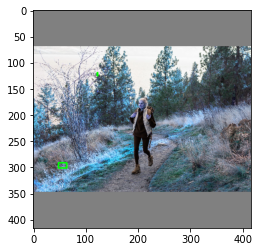

In [30]:
def test_image(image):
    darknet.eval()
    with torch.no_grad():
        img = torch.cuda.FloatTensor(image).unsqueeze(0) 
        img = img.view(img.shape[0], img.shape[3], img.shape[2], img.shape[2])
        pred = darknet(img)
        pred = predict_transform(pred, anchors, 416, 0.6)
        pred = draw_grid(pred, image)
    darknet.train()
    return pred

image = test_image(pad_img)
plt.imshow(image)

In [10]:
def iou(boxA,boxB):
    # boxA = boxB = [x1,y1,x2,y2]

    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection
    intersection_area = (xB - xA + 1) * (yB - yA + 1)

    # Compute the area of both rectangles
    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Compute the IOU
    iou = intersection_area / float(boxA_area + boxB_area - intersection_area)

    return iou